# Character Convolutions for Text Classification

**Contents**

* [Load and Format Data](#data)
  * [Tokenization and Padding](#tokenandpad)
  * [Sequence Sizing](#sizing)
  * [Check Translation](#check)
* [Model](#model)
  *  [Architecture](#archi)
    *  [Model Summary and Image](#modelsummary)
  *  [Fit and Results](#fitandresults)
*  [Comparisons to Other Models](#comparisons)
  *  [LSTM Model](#lstm)
  *  [Universal Sentence Encoder Model](#use)
  *  [Comparison](#compare)

**Run Instructions**

Before running this notebook, run `./download.sh` to download the data or download the data manually from [here](http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip) and place the training data at `./`.

In [29]:
# library imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

from src.data import (
    get_data, 
    CharacterTranslator,
)
from src.model import (
    get_convolutional_model,
    get_recurrent_model,
    get_use_model
)
from src.util import plot_loss_accuracy

## Load and Format Data <a id="data"></a>

The data used in this example is a set of 1.6 million tweets labeled with sentiment (0, 1) collected by Go et al.
More details can be found at:

[https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf](https://www-cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

`get_data` reads the data files and creates training and test sets (`X_train`, `X_test`).
The label vectors (`y_train`, `y_test`) are one-hot encoded to represent the target, which is binary in this case.

In [2]:
X_train, X_test, y_train, y_test = get_data()

In [3]:
print(f'Training records: {X_train.shape[0]:11}.\nTest records: {X_test.shape[0]:15}.')

Training records:     1280000.
Test records:          320000.


Examples of `X_train`

In [4]:
X_train[0:2]

array(['@chrishasboobs ahhh i hope your ok!!! ',
       '@misstoriblack cool , i have no tweet apps for my razr 2'],
      dtype=object)

Examples of `y_train`

In [5]:
y_train[0:2]

array([[1., 0.],
       [1., 0.]], dtype=float32)

## Tokenize and Pad Sequences <a id="tokenandpad"></a>

The `CharacterTranslator` is used to fit a character dictionary on the raw text.
Then it is used to convert the raw text to numeric-encoded sequences.

There are 3 special tokens `<OOV>`, `<pad>`, and `<start>`. 
`<OOV>` (out-of-vocabulary) is used to represent characters outside of the dictionary.
Note that the `CharacterTranslator` is only fit on the training data.
`<pad>` is used to pad short sequences up to the input size.
`<start>` is not used in this case.

In [6]:
char_translator = CharacterTranslator()
char_translator.fit(X_train)

**Characters from translator fit**

In [7]:
print(list(char_translator.str_to_token.keys()))

['<start>', '<pad>', '<OOV>', ' ', 'e', 't', 'o', 'a', 'i', 'n', 's', 'r', 'h', 'l', 'd', 'm', 'u', 'y', 'g', 'w', 'c', '.', 'p', 'f', 'b', 'k', '!', 'v', '@', "'", ',', 'j', '/', 'x', '?', 'z', ';', '-', '&', '1', ':', '2', 'q', '0', '3', '_', '4', '5', '6', '8', '7', '9', ')', '#', '(', '*', 'ð', '=', 'â', '~', '½', '$', '¿', 'ñ', '+', 'ï', 'ã', ']', '\x99', '\x80', '^', '[', '¸', '|', '%', '´', '°', '¾', 'à', 'µ', '\x82', '¥', '`', '»', 'º', '«', 'á', '£', 'ø', 'ì', 'ù', '²', '¼', '\x83', '\\', '¡', '©', 'ä', '¹', '\x84', '±', 'ë', '³', '×', '§', '¬', '\x88', '\x8b', '\x87', '¤', 'å', '\x8c', '¦', 'ª', '¶', '·', '\xa0', '\x95', 'î', '\xad', '\x91', 'æ', '\x9c', '\x98', '\x94', '}', '\x8a', '{', '¯', '\x86', '\x93', '\x85', 'ê', '¢', '¨', '®', '\x9f', '\x89', '\x9a', '\x96', '\x8e', '\x9b', 'í', '\x97', '\x9e', 'è', 'é', 'ç', '\x92', '\t', 'û', '\x7f', 'ú', 'ó', 'ò', 'ß']


**Tokenization Example**

In [8]:
token_ex = char_translator._tokenize(X_train[:1], True)
print('Raw:')
print(X_train[1])
print('\n','_______________________','\n')
print('Tokenized:')
print(token_ex[0])

Raw:
@misstoriblack cool , i have no tweet apps for my razr 2

 _______________________ 

Tokenized:
['@', 'c', 'h', 'r', 'i', 's', 'h', 'a', 's', 'b', 'o', 'o', 'b', 's', ' ', 'a', 'h', 'h', 'h', ' ', 'i', ' ', 'h', 'o', 'p', 'e', ' ', 'y', 'o', 'u', 'r', ' ', 'o', 'k', '!', '!', '!', ' ']


### Sequence Sizing  <a id="sizing"></a>

A sequence size of ~150 appears to be sufficient to capture most of the sequences.
However, the minimum input sequence size for this model is 160.
So 160 will be used as the input size.

In [9]:
max_sequence_length = 160

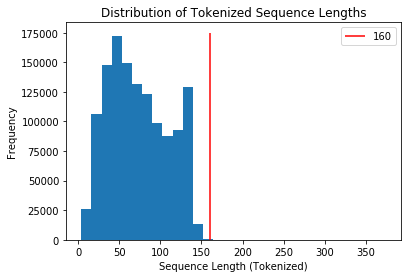

In [10]:
plt.hist(char_translator.seq_sizes, bins=30);
plt.vlines(max_sequence_length, 0, 175000, label='160', color='red');
plt.title('Distribution of Tokenized Sequence Lengths');
plt.xlabel('Sequence Length (Tokenized)');
plt.ylabel('Frequency');
plt.legend();

In [11]:
X_train_encoded = char_translator.transform(X_train, maxlen=max_sequence_length)
X_test_encoded = char_translator.transform(X_test, maxlen=max_sequence_length)

**Sequence Encoding Examples** <a id="check"></a>

Sequences shorter than 160 tokens are zero padded (pre-padding) and sequences longer than 160 are truncated (pre-truncation) to make all sequence lengths 160.

In [12]:
print('Raw:')
print(X_train[4])
print('\n','_______________________','\n')
print('Encoded:')
print(X_train_encoded[4])
print('\n','_______________________','\n')
print('Reverse Transformed:')
print(char_translator.inverse_transform(X_train_encoded[4:5]))

Raw:
upper airways problem 

 _______________________ 

Encoded:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16 22 22  4 11  3
  7  8 11 19  7 17 10  3 22 11  6 24 13  4 15  3]

 _______________________ 

Reverse Transformed:
['<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

## Model <a id="model"></a>

The model implementation is build by `get_convolutional_model`.
This function takes the vocabulary size, the max sequence length, and the number of classes.

### Architecture <a id="archi"></a>

The architecture of the model is described in section 2.3 of the [paper](https://arxiv.org/pdf/1509.01626.pdf).

#### Convolutions with Pooling

There are 6 convolutions with 3 pooling operations.

|  Layer  | ConV Layer Name | Large Feature | Small Feature | Kernel | Pool | Pool Layer Name |
|:-------:|:---------------:|:-------------:|:-------------:|:------:|:----:|:---------------:|
| 1             |  conv_1   |   1024        |   256         | 7      |  3   | pooling_1  |
| 2             | conv_2    |   1024        |   256         | 7      |  3   | pooling_2  |
| 3             |  conv_3   |   1024        |   256         | 3      |  N/A | N/A  |
| 4             | conv_4    |   1024        |   256         | 3      |  N/A | N/A  |
| 5             |  conv_5   |   1024        |   256         | 3      |  N/A | N/A  |
| 6             | conv_6    |   1024        |   256         | 3      |  3   | pooling_3  |

#### Dense and Output

|  Layer  | Name | Large Feature | Small Feature |
|:-------:|:---------------:|:-------------:|:-------------:|
| 7       |  dense_out_1   |   2048        |   1024         |
| 8       | dense_out_2    |   2048        |   1024         |
| 9       |  output        |   Number of Classes   |   Number of Classes |

Dropout of probability of 0.5 is included between each fully connected layer.


In [40]:
model = get_convolutional_model(char_translator.vocab_size,
                                max_sequence_length, 
                                2) # 2 is the number of classes

#### Model Summary and Image <a id="modelsummary"></a>

In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
character_embedding (Embeddi (None, 160, 300)          46800     
_________________________________________________________________
input_dropout (Dropout)      (None, 160, 300)          0         
_________________________________________________________________
conv_1 (Conv1D)              (None, 154, 256)          537856    
_________________________________________________________________
pooling_1 (MaxPooling1D)     (None, 51, 256)           0         
_________________________________________________________________
conv_2 (Conv1D)              (None, 45, 256)           459008    
_________________________________________________________________
pooling_2 (MaxPooling1D)     (None, 15, 256)           0         
_________________________________________________________________
conv_3 (Conv1D)              (None, 13, 256)          

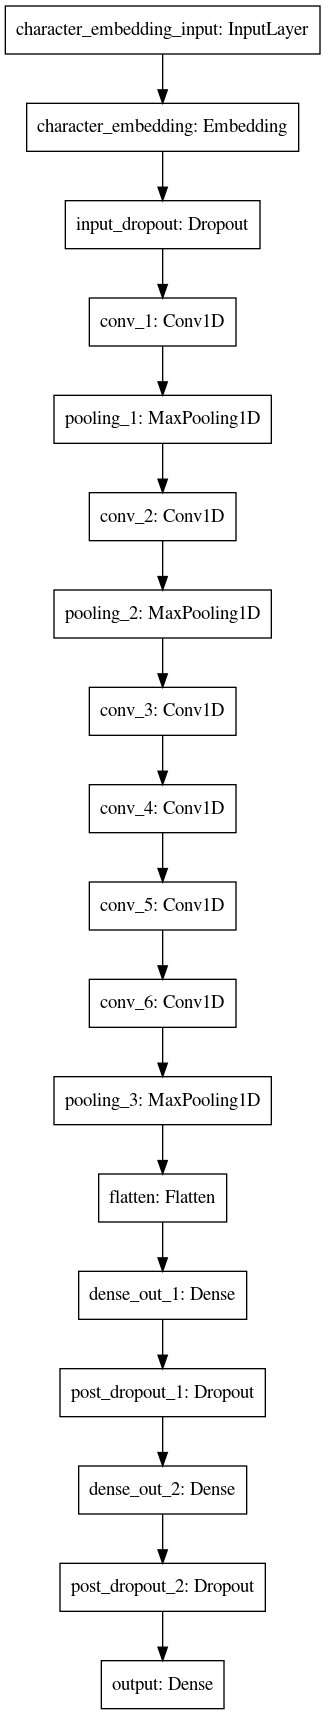

In [16]:
#plot_model(model, to_file='./images/model.png')

In [42]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Fit and Results <a id="modelsummary"></a>

The loss plots show that the model fits in a small number of epochs.
Also, note the (relatively) short runtime per epoch.

In [43]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2)

hist = model.fit(X_train_encoded, y_train,
          validation_data=(X_test_encoded, y_test),
          epochs=15, batch_size=1000,
          callbacks=[es])

Epoch 1/15
1280/1280 [==============================] - 311s 243ms/step - loss: 0.4866 - accuracy: 0.7559 - val_loss: 0.4211 - val_accuracy: 0.8058
Epoch 2/15
1280/1280 [==============================] - 317s 248ms/step - loss: 0.4098 - accuracy: 0.8129 - val_loss: 0.4048 - val_accuracy: 0.8177
Epoch 3/15
1280/1280 [==============================] - 316s 247ms/step - loss: 0.3896 - accuracy: 0.8240 - val_loss: 0.3947 - val_accuracy: 0.8211
Epoch 4/15
1280/1280 [==============================] - 313s 244ms/step - loss: 0.3755 - accuracy: 0.8320 - val_loss: 0.3925 - val_accuracy: 0.8222
Epoch 5/15
1280/1280 [==============================] - 313s 244ms/step - loss: 0.3626 - accuracy: 0.8385 - val_loss: 0.3923 - val_accuracy: 0.8223
Epoch 6/15
1280/1280 [==============================] - 312s 244ms/step - loss: 0.3499 - accuracy: 0.8450 - val_loss: 0.3934 - val_accuracy: 0.8221
Epoch 7/15
1280/1280 [==============================] - 313s 244ms/step - loss: 0.3371 - accuracy: 0.8517 - val_

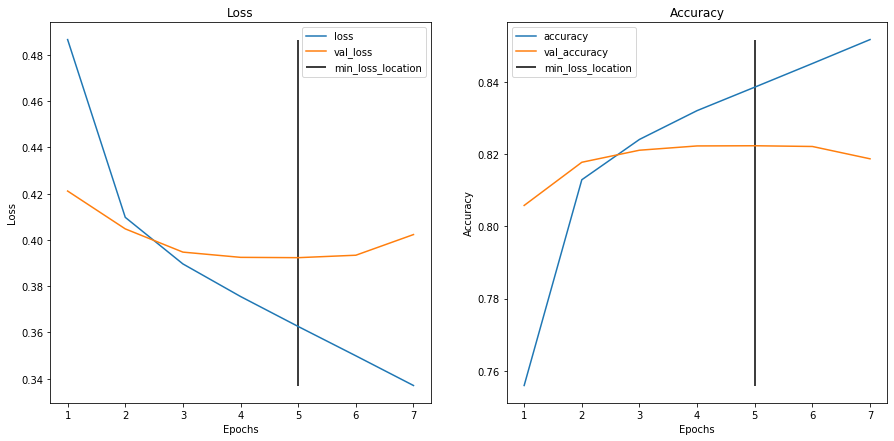

In [45]:
plot_loss_accuracy(hist)

## Comparisons to Other Models <a id="comparisons"></a>

Two other models are used for comparison: a bidirectional LSTM and the [Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4).


### LSTM Model <a id="lstm"></a>

In [14]:
lstm_model = get_recurrent_model(char_translator.vocab_size,
                                 max_sequence_length, 
                                 2) # 2 is the number of classes
# the following warnings are ok based on this issue
# https://github.com/tensorflow/tensorflow/issues/40944

In [15]:
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 160, 300)          46800     
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               320800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 368,002
Trainable params: 368,002
Non-trainable params: 0
_________________________________________________________________


In [16]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3)

lstm_history = lstm_model.fit(
    X_train_encoded, y_train,
    validation_data=(X_test_encoded, y_test),
    epochs=100, batch_size=1000,
    callbacks=[es])

Epoch 1/100
1280/1280 [==============================] - 832s 650ms/step - loss: 0.5841 - accuracy: 0.6865 - val_loss: 0.5055 - val_accuracy: 0.7512
Epoch 2/100
1280/1280 [==============================] - 826s 646ms/step - loss: 0.4824 - accuracy: 0.7675 - val_loss: 0.4446 - val_accuracy: 0.7919
Epoch 3/100
1280/1280 [==============================] - 823s 643ms/step - loss: 0.4435 - accuracy: 0.7928 - val_loss: 0.4184 - val_accuracy: 0.8075
Epoch 4/100
1280/1280 [==============================] - 833s 651ms/step - loss: 0.4234 - accuracy: 0.8050 - val_loss: 0.4054 - val_accuracy: 0.8157
Epoch 5/100
1280/1280 [==============================] - 833s 650ms/step - loss: 0.4109 - accuracy: 0.8123 - val_loss: 0.3984 - val_accuracy: 0.8200
Epoch 6/100
1280/1280 [==============================] - 831s 649ms/step - loss: 0.4026 - accuracy: 0.8169 - val_loss: 0.3876 - val_accuracy: 0.8257
Epoch 7/100
1280/1280 [==============================] - 835s 652ms/step - loss: 0.3961 - accuracy: 0.8209

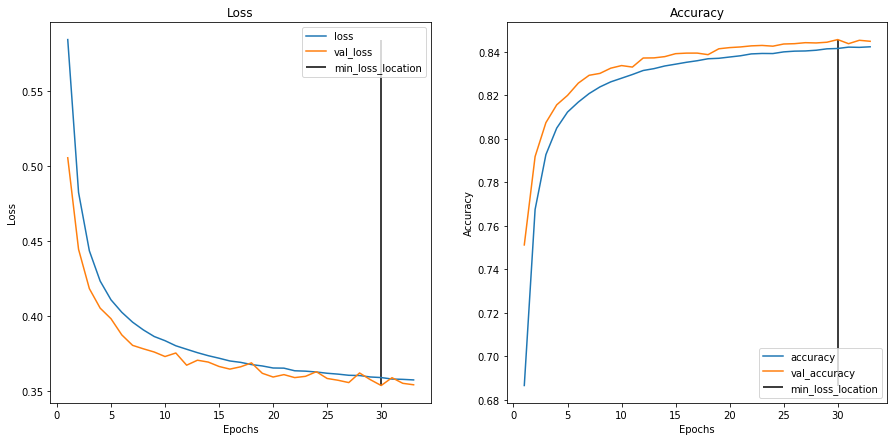

In [59]:
plot_loss_accuracy(lstm_history)

### Universal Sentence Encoder Model <a id="use"></a>

In [18]:
use_model = get_use_model(2) # 2 is the number of classes

In [19]:
use_model.summary()
use_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 256,929,666
Trainable params: 131,842
Non-trainable params: 256,797,824
_________________________________________________________________


In [26]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3)

use = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                     trainable=False,
                     input_shape=[], 
                     dtype=tf.string)

use_model = Sequential()
use_model.add(use)
use_model.add(layers.Dropout(0.2))
use_model.add(layers.Dense(256, activation = 'relu'))
use_model.add(layers.Dropout(0.2))
use_model.add(layers.Dense(2, activation='softmax'))

use_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


use_history = use_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=1000,
    callbacks=[es])


Epoch 1/100
1280/1280 [==============================] - 92s 71ms/step - loss: 0.4604 - accuracy: 0.7813 - val_loss: 0.4322 - val_accuracy: 0.7981
Epoch 2/100
1280/1280 [==============================] - 91s 71ms/step - loss: 0.4410 - accuracy: 0.7928 - val_loss: 0.4265 - val_accuracy: 0.8011
Epoch 3/100
1280/1280 [==============================] - 91s 71ms/step - loss: 0.4357 - accuracy: 0.7960 - val_loss: 0.4240 - val_accuracy: 0.8028
Epoch 4/100
1280/1280 [==============================] - 91s 71ms/step - loss: 0.4327 - accuracy: 0.7976 - val_loss: 0.4219 - val_accuracy: 0.8042
Epoch 5/100
1280/1280 [==============================] - 91s 71ms/step - loss: 0.4305 - accuracy: 0.7992 - val_loss: 0.4206 - val_accuracy: 0.8042
Epoch 6/100
1280/1280 [==============================] - 91s 71ms/step - loss: 0.4287 - accuracy: 0.8003 - val_loss: 0.4197 - val_accuracy: 0.8055
Epoch 7/100
1280/1280 [==============================] - 92s 72ms/step - loss: 0.4274 - accuracy: 0.8010 - val_loss: 0

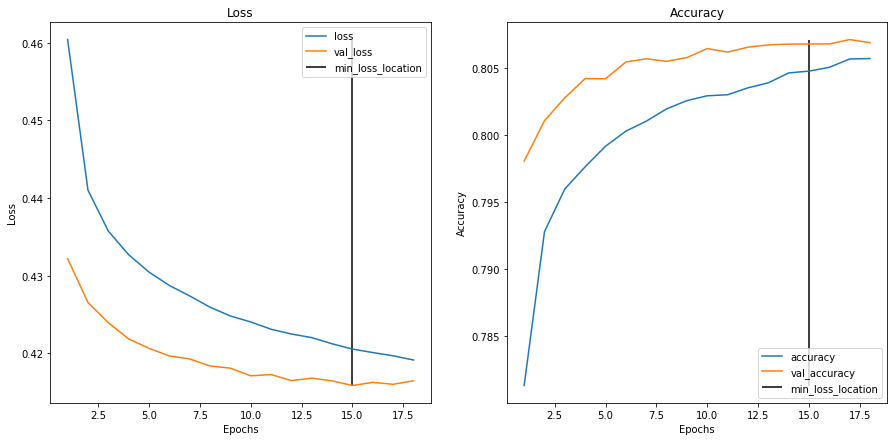

In [60]:
plot_loss_accuracy(use_history)

### Model Comparison <a id="compare"></a>

Overall, the LSTM exhibits the highest accuracy, but also the longest training time.
The ConvNet model comes in second in both accuracy and training time.
The USE model has the shortest training time and lowest accuracy.

The ConvNet model represents a nice middle ground between the three models.
It has a relatively short training time for a reasonably good validation accuracy.

#### Fit Times

The fit times are shown below.
The plot of the total time shows that the bidirectional LSTM takes significantly longer to fit than the other two models (based on the same stopping criteria).
The plot of the mean epoch time shows a similar story - 
the bidirectional LSTM takes much longer to train than the other two models 
(about 2x the ConvNet time and about 8x the USE time).

#### Validation Accuracy

The validation accuracies for each model are shown below.
The validation accuracies only differ by about ~2% points.

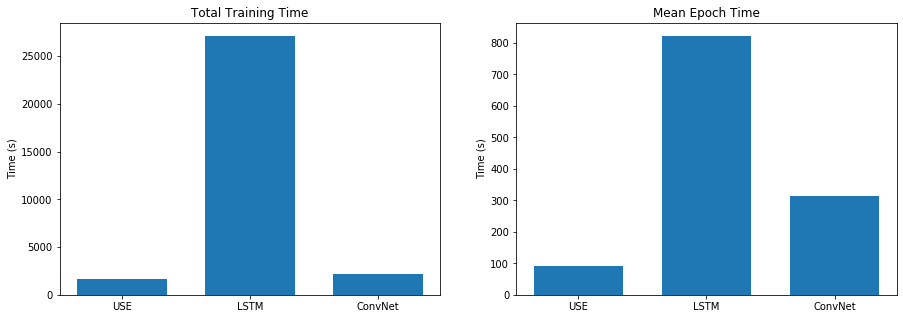

In [58]:
cov_times = np.array([311, 317, 316, 313, 313, 312, 313])
lstm_times = np.array([
    832, 826, 823, 833, 833, 831, 835, 821, 821, 821, 821,
    821, 822, 826, 827, 824, 825, 824, 822, 825, 827, 816,
    816, 816, 816, 816, 816, 816, 816, 816, 815, 815, 816])
use_times = np.array([91] * 16 + [92] * 2)
ind = np.arange(3) 
width = 0.7    
fig, ax = plt.subplots(ncols=2, figsize = (15, 5))
ax[0].bar(ind, [use_times.sum(), lstm_times.sum(), cov_times.sum()], width);
ax[0].set_xticks(ind)
ax[0].set_xticklabels(('USE','LSTM', 'ConvNet'))
ax[0].set_title('Total Training Time');
ax[0].set_ylabel('Time (s)')
ax[1].bar(ind, [use_times.mean(), lstm_times.mean(), cov_times.mean()], width);
ax[1].set_xticks(ind)
ax[1].set_xticklabels(('USE','LSTM', 'ConvNet'))
ax[1].set_title('Mean Epoch Time')
ax[1].set_ylabel('Time (s)');
#fig.savefig('./model_training_time_compare.png')

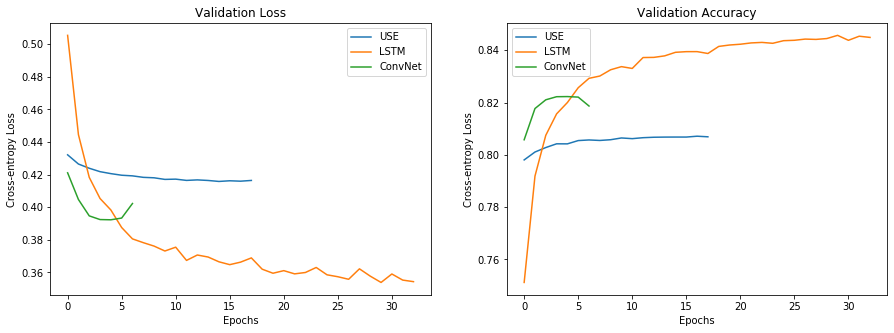

In [57]:
fig, ax = plt.subplots(ncols=2, figsize = (15, 5))
ax[0].plot(use_history.history['val_loss'], label='USE')
ax[0].plot(lstm_history.history['val_loss'], label='LSTM')
ax[0].plot(hist.history['val_loss'], label='ConvNet')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Cross-entropy Loss')
ax[0].set_title('Validation Loss')
ax[0].legend();
ax[1].plot(use_history.history['val_accuracy'], label='USE')
ax[1].plot(lstm_history.history['val_accuracy'], label='LSTM')
ax[1].plot(hist.history['val_accuracy'], label='ConvNet')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Cross-entropy Loss')
ax[1].set_title('Validation Accuracy')
ax[1].legend();
#fig.savefig('./images/model_performance_compare.png')